# Checking if BWS85 can see the blowup of the wire

- BWS85 triggered any turn
- BWS64 triggered once every two turns as blowup source

In [1]:
# Quick fix for the usual Swan problems... --> Unnecessay ATM
# %run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.21.1.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.13
2018-10-03 16:07:52


In [140]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.32
2018-10-08 13:36:33
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

Ok let's forget matlab and use the data from TIMBER

In [141]:
# Alex's way
ts1 = '2018-09-24 11:52:07.900'
ts2 = '2018-09-24 14:53:42.700'

PSuser = 'CPS:MD4404_BCMS:MD3'

variables = ['PR.DCAFTINJ_1:INTENSITY']
WS_variables = ['PR.BWS.64.V_ROT:PROF_POSITION_IN', 'PR.BWS.64.V_ROT:PROF_DATA_IN','PR.BWS.85.V_ROT:PROF_POSITION_IN', 'PR.BWS.85.V_ROT:PROF_DATA_IN']

myDataFrame = myToolbox.fromTimberToDataFrame(variables, ts1, ts2, fundamental = PSuser)
myToolbox.addToDataFrameFromCALS(myDataFrame, WS_variables)

In [142]:
# kill shots that have nothing
index_to_drop = myDataFrame.loc[( myDataFrame['PR.BWS.64.V_ROT:PROF_POSITION_IN'].isnull() ) & ( myDataFrame['PR.BWS.64.V_ROT:PROF_DATA_IN'].isnull() ) & ( myDataFrame['PR.BWS.85.V_ROT:PROF_POSITION_IN'].isnull() ) & ( myDataFrame['PR.BWS.85.V_ROT:PROF_DATA_IN'].isnull() )]. index
myDataFrame = myDataFrame.drop(index_to_drop)

# BWS64 swinging flag

In [143]:
myDataFrame['WS64_on'] = np.logical_not(myDataFrame['PR.BWS.64.V_ROT:PROF_POSITION_IN'].isnull())

# Rename fields for transparency with the existing script

In [144]:
myDataFrame['Intensity_max'] = myDataFrame['PR.DCAFTINJ_1:INTENSITY']
myDataFrame = myDataFrame.drop('PR.DCAFTINJ_1:INTENSITY',axis=1)

# Cleanup

In [145]:
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-24 14:48:45.100000'].name) # wirescanner fault

# Calculate wire scanner sigma

## BWS 85

In [146]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR.BWS.85.V_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR.BWS.85.V_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR.BWS.85.V_ROT:PROF_DATA_IN'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS85_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS85_sigma_y'] = myDataFrame['WS85_fit_results_y'].apply(lambda x: x[0][-1])
myDataFrame['WS85_mean_y'] = myDataFrame['WS85_fit_results_y'].apply(lambda x: x[0][-2])

## BWS 64

In [147]:
# fill the holes to avoid the algorithm to blow up
myDataFrame['BWS64_position'] = [np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['BWS64_position_idx'] = [np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['BWS64_data'] = [np.empty(0,dtype=float)]*len(myDataFrame)


In [148]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS64_position'] = myDataFrame['PR.BWS.64.V_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS64_position_idx'] = myDataFrame['PR.BWS.64.V_ROT:PROF_POSITION_IN'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS64_data'] = myDataFrame['BWS64_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    try:
        myDataFrame['BWS64_data'].iloc[r] = np.interp(pos, myDataFrame['BWS64_position'].iloc[r], myDataFrame['PR.BWS.64.V_ROT:PROF_DATA_IN'].iloc[r][myDataFrame['BWS64_position_idx'].iloc[r]])  
    except:
        myDataFrame['BWS64_data'].iloc[r] = np.nan
        
        
# fuck this pandas shit let's go the stupid way
a = []
for lab in myDataFrame.index:
    try:
        a.append( myToolbox.makeGaussianFit_5_parameters(pos, myDataFrame['BWS64_data'].loc[lab]) )
    except:
        a.append( np.nan )
myDataFrame['WS64_fit_results_y'] = a # reconversion to pandas

# get sigma or nan
def sigma_or_nan(x):
    try:
        x = x[0][-1]
    except:
        x = x
    return x

def mean_or_nan(x):
    try:
        x = x[0][-2]
    except:
        x = x
    return x

myDataFrame['WS64_sigma_y'] = myDataFrame['WS64_fit_results_y'].apply(sigma_or_nan)
myDataFrame['WS64_mean_y'] = myDataFrame['WS64_fit_results_y'].apply(mean_or_nan)


In [176]:
plt.axhline?

# Check the sigma with and without scattering

Using two wirescanners:		 2.45859227638 +/- 0.0343596144452
Using a single wirescanners:	 2.42456413596 +/- 0.0294709587686
				 ----------------------------------
Difference:			 1.4034745425 %


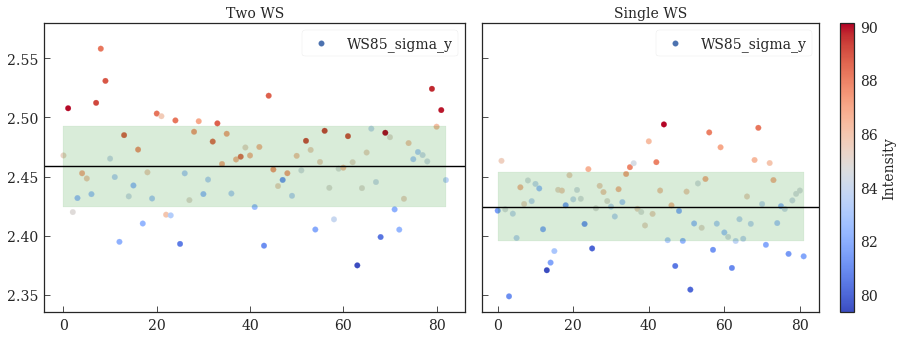

In [197]:
fig, ax = plt.subplots(1,2,figsize=(13,5), sharey=True)

yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
p1 = ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
# clb = fig.colorbar(p1)
# clb.set_label('Beam brightness')
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

#statistical stuff
mean_two_ws =  np.mean(yy1); std_two_ws = np.std(yy1)
ax[0].axhline(y=mean_two_ws, xmin=ax[0].get_xlim()[0],xmax=ax[0].get_xlim()[1], c='k')
ax[0].fill_between(xx, mean_two_ws-std_two_ws, mean_two_ws+std_two_ws, color='g',alpha=0.15  )

yy = myDataFrame['WS85_sigma_y'].loc[(myDataFrame['WS64_on'] == False)]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max'].loc[(myDataFrame['WS64_on'] == False)]

p2 = ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p2)
clb.set_label('Intensity')
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')


# statistical stuff
mean_one_ws =  np.mean(yy); std_one_ws = np.std(yy)
ax[1].axhline(y=mean_one_ws, xmin=ax[1].get_xlim()[0],xmax=ax[1].get_xlim()[1], c='k')
ax[1].fill_between(xx, mean_one_ws-std_one_ws, mean_one_ws+std_one_ws, color='g',alpha=0.15  )



print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*np.abs( mean_two_ws/ mean_one_ws- 1))+str(' %'))

fig.tight_layout()

Using two wirescanners:		 3.39820528337 +/- 0.125765298311
Using a single wirescanners:	 nan +/- nan
				 ----------------------------------
Difference:			 nan %


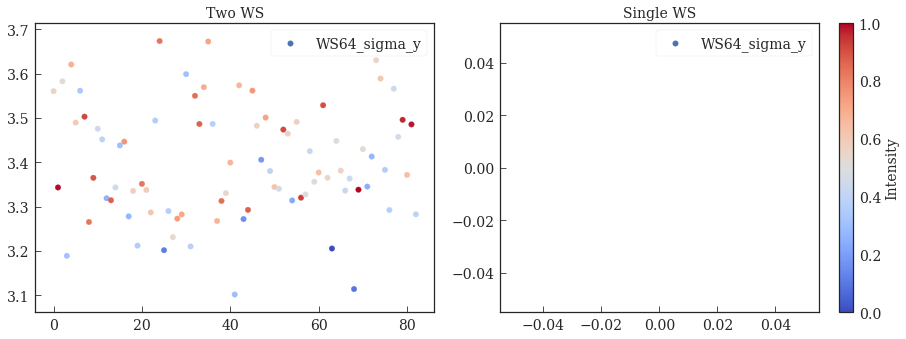

In [153]:
# check BWS64 when it was scanning
fig, ax = plt.subplots(1,2,figsize=(13,5), sharey=False)

yy = myDataFrame['WS64_sigma_y'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
p1 = ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
# clb = fig.colorbar(p1)
# clb.set_label('Beam brightness')
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

yy = myDataFrame['WS64_sigma_y'].loc[(myDataFrame['WS64_on'] == False)]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max'].loc[(myDataFrame['WS64_on'] == False)]

p2 = ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p2)
clb.set_label('Intensity')
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

fig.tight_layout()

# Same stuff, but with intensity normalisation

- This makes sense for the single wire data ! The others are already remixed by the scattering

In [162]:
myDataFrame['WS85_sigma_y_corrected'] = np.nan

(array([ 1.43338339,  0.01176608]), array([  4.89924261e-03,   6.89942127e-07]))


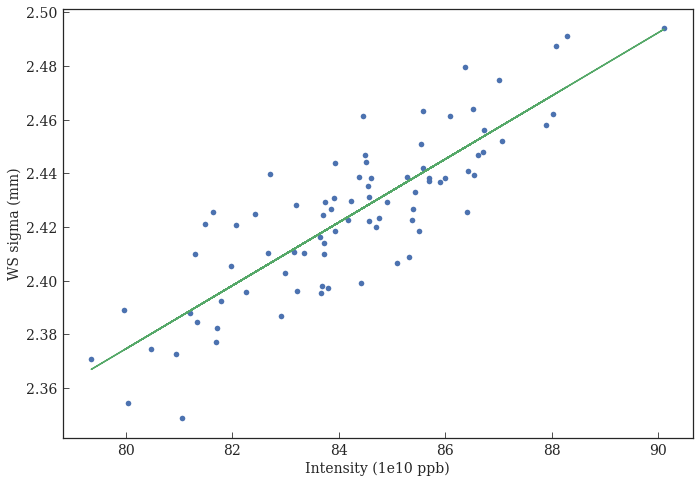

In [198]:
# find correlation parameter for the single wirescanner one 
xx = myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==False]
yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==False]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [200]:
# using manual scaling
def scale_sigma(intensity, sigma):
    '''
    Scale the sigma due to the Intensity of 85e10 ppb
    '''
    a = 1.43338339
    b = 0.01176608
    
    corr_factor = lin(intensity, a, b) / lin(85, a, b)
    return sigma/corr_factor

myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on']==False] = scale_sigma(myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==False], myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==False])



(array([ 1.37109535,  0.01295776]), array([  7.30567330e-03,   1.03651307e-06]))


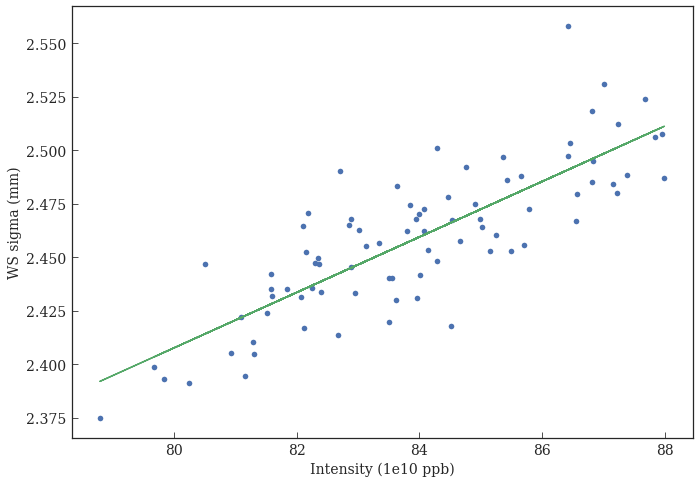

In [201]:
# find correlation parameter for the single wirescanner one 
xx = myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==True]
yy = myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==True]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [202]:
# using manual scaling
def scale_sigma(intensity, sigma):
    '''
    Scale the sigma due to the Intensity of 85e10 ppb
    '''
    a = 1.37109535
    b = 0.01295776
    
    corr_factor = lin(intensity, a, b) / lin(85, a, b)
    return sigma/corr_factor

myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on']==True] = scale_sigma(myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on']==True], myDataFrame['WS85_sigma_y'].loc[myDataFrame['WS64_on']==True])




Using two wirescanners:		 2.4725042055 +/- 0.0199255729687
Using a single wirescanners:	 2.43350054248 +/- 0.0158273459754
				 ----------------------------------
Difference:			 1.60278012452 %


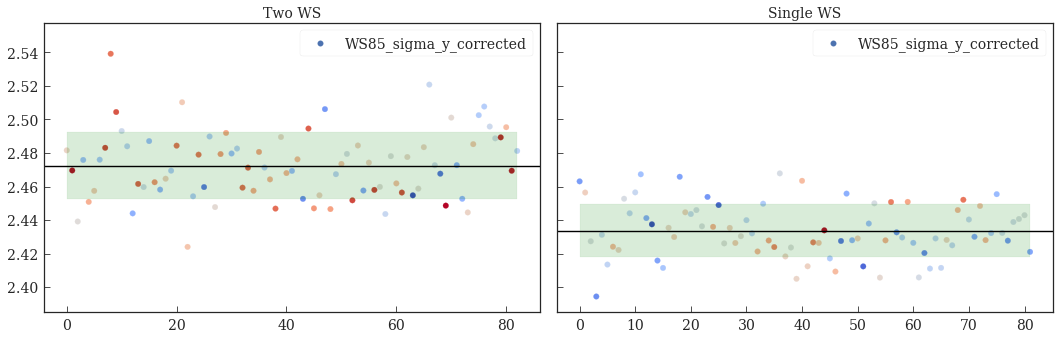

In [204]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)

yy = myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on'] == True];  yy1=yy
xx = np.linspace(0, len(yy)-1, len(yy))
cc= myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == True]
ax[0].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
ax[0].legend(frameon=True)
ax[0].set_title('Two WS')
print('Using two wirescanners:\t\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))

#statistical stuff
mean_two_ws =  np.mean(yy1); std_two_ws = np.std(yy1)
ax[0].axhline(y=mean_two_ws, xmin=ax[0].get_xlim()[0],xmax=ax[0].get_xlim()[1], c='k')
ax[0].fill_between(xx, mean_two_ws-std_two_ws, mean_two_ws+std_two_ws, color='g',alpha=0.15  )



yy = myDataFrame['WS85_sigma_y_corrected'].loc[myDataFrame['WS64_on'] == False ]
xx = np.linspace(0, len(yy)-1, len(yy))
cc = myDataFrame['Intensity_max'].loc[myDataFrame['WS64_on'] == False ]

ax[1].scatter(xx, yy, c = cc, cmap=plt.cm.coolwarm)
ax[1].legend(frameon=True)
ax[1].set_title('Single WS')
print('Using a single wirescanners:\t '+str(np.mean(yy))+' +/- '+str(np.std(yy)))
print('\t\t\t\t ----------------------------------')
print('Difference:\t\t\t '+str(100*( np.mean(yy1)/np.mean(yy) - 1))+str(' %'))

# statistical stuff
mean_one_ws =  np.mean(yy); std_one_ws = np.std(yy)
ax[1].axhline(y=mean_one_ws, xmin=ax[1].get_xlim()[0],xmax=ax[1].get_xlim()[1], c='k')
ax[1].fill_between(xx, mean_one_ws-std_one_ws, mean_one_ws+std_one_ws, color='g',alpha=0.15  )


fig.tight_layout()

# Conclusions

- **MATLAB timestamps are occasionally wrong** for the proper ones, use TIMBER
- As usual there is a correlation between the intensity and the sigma coming from the booster phase space painting
- The scattering is visible. A difference between the 1.4 and 1.5 % is appreciated, depending on data treatment (nomalisation with intensity)

- **Still, the correlation between the intensity and the sigma is not that visible on BWS64**